# American Community Survey - California - 2017 Analysis

In this notebook, I will practice conducting statistical tests and visualizing data within Python. 

The data I'm using comes from the 2017 American Community Survey. I am looking at data from the 15 most populous counties in California only. The table I am using is "Selected Characteristics of People at Specified Levels of Poverty in the Past 12 Months." This will allow us to see how poverty levels differ in different counties of California and among different populations.

In [3]:
# Libraries
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency

## Data Preparation

Let's import and clean up the data.

In [4]:
# Import data file
raw_data = pd.read_csv('ACS_17_1YR_S1703_with_ann.csv')
metadata = pd.read_csv('ACS_17_1YR_S1703_metadata.csv')

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Columns: 283 entries, GEO.id to HC04_MOE_VC51
dtypes: object(283)
memory usage: 35.5+ KB


In [6]:
raw_data.head(5)

,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC01,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,HC03_MOE_VC01,HC04_EST_VC01,...,HC04_EST_VC50,HC04_MOE_VC50,HC01_EST_VC51,HC01_MOE_VC51,HC02_EST_VC51,HC02_MOE_VC51,HC03_EST_VC51,HC03_MOE_VC51,HC04_EST_VC51,HC04_MOE_VC51
0,Id,Id2,Geography,Total; Estimate; Population for whom poverty s...,Total; Margin of Error; Population for whom po...,Less than 50 percent of the poverty level; Est...,Less than 50 percent of the poverty level; Mar...,Less than 100 percent of the poverty level; Es...,Less than 100 percent of the poverty level; Ma...,Less than 125 percent of the poverty level; Es...,...,Less than 125 percent of the poverty level; Es...,Less than 125 percent of the poverty level; Ma...,Total; Estimate; WORK STATUS - Population 16 t...,Total; Margin of Error; WORK STATUS - Populati...,Less than 50 percent of the poverty level; Est...,Less than 50 percent of the poverty level; Mar...,Less than 100 percent of the poverty level; Es...,Less than 100 percent of the poverty level; Ma...,Less than 125 percent of the poverty level; Es...,Less than 125 percent of the poverty level; Ma...
1,0500000US06001,06001,"Alameda County, California",1636780,2648,4.4,0.4,9.2,0.5,12.1,...,17.1,1.5,231484,7735,14.8,1.5,24.6,1.5,29.2,1.6
2,0500000US06013,06013,"Contra Costa County, California",1138850,1328,4.2,0.6,9.3,0.9,12.4,...,14.1,1.7,168044,7131,13.6,1.9,22.6,2.8,28.2,3.0
3,0500000US06019,06019,"Fresno County, California",972580,1778,9.0,0.9,21.1,1.3,27.9,...,32.9,2.5,177421,6349,19.1,2.3,36.6,2.4,43.9,2.5
4,0500000US06029,06029,"Kern County, California",860951,2581,9.8,1.0,21.4,1.6,28.9,...,29.6,3.0,179140,7436,19.4,2.3,35.5,3.0,44.9,3.2


Our file has nonintuitive column names and a descriptor row. This is a problem because Pandas is storing every column as an object, since every column has a string value. 

We could write some code to fix that here in our notebook, but it will be faster to save a DataFrame without the string descriptor row to our computer and then reimport it, so Pandas can automatically read it correctly. 

While we're at it, let's change the county names to be shorter so we don't have to keep manually doing this later on.

In [7]:
fixed_data = raw_data[raw_data['GEO.id2'] != 'Id2'].reset_index()
fixed_data['GEO.display-label'] = fixed_data['GEO.display-label'].apply(lambda x: x.split(' County')[0])
fixed_data.to_csv('ACS_17_1YR_S1703_FIXED.csv')
data = pd.read_csv('ACS_17_1YR_S1703_FIXED.csv')
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Columns: 285 entries, Unnamed: 0 to HC04_MOE_VC51
dtypes: float64(210), int64(73), object(2)
memory usage: 33.5+ KB


,Unnamed: 0,index,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC01,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,...,HC04_EST_VC50,HC04_MOE_VC50,HC01_EST_VC51,HC01_MOE_VC51,HC02_EST_VC51,HC02_MOE_VC51,HC03_EST_VC51,HC03_MOE_VC51,HC04_EST_VC51,HC04_MOE_VC51
0,0,1,0500000US06001,6001,Alameda,1636780,2648,4.4,0.4,9.2,...,17.1,1.5,231484,7735,14.8,1.5,24.6,1.5,29.2,1.6
1,1,2,0500000US06013,6013,Contra Costa,1138850,1328,4.2,0.6,9.3,...,14.1,1.7,168044,7131,13.6,1.9,22.6,2.8,28.2,3.0
2,2,3,0500000US06019,6019,Fresno,972580,1778,9.0,0.9,21.1,...,32.9,2.5,177421,6349,19.1,2.3,36.6,2.4,43.9,2.5
3,3,4,0500000US06029,6029,Kern,860951,2581,9.8,1.0,21.4,...,29.6,3.0,179140,7436,19.4,2.3,35.5,3.0,44.9,3.2
4,4,5,0500000US06037,6037,Los Angeles,10015695,5187,6.1,0.2,14.9,...,21.3,0.6,1713389,17864,17.3,0.7,30.6,0.8,37.3,0.8


Fixed! Let's move on.

This is a very large file with many variables. We only want to analyze poverty by county, sex, and disability. Let's separate our DataFrame into smaller DataFrames with descriptive column names to make our analysis easier. 

### Poverty by County

In [8]:
data_county = data[['GEO.id2', 'GEO.display-label', 'HC01_EST_VC01', 'HC01_MOE_VC01', 'HC02_EST_VC01', 'HC02_MOE_VC01', 'HC03_EST_VC01', 'HC03_MOE_VC01', 'HC04_EST_VC01', 'HC04_MOE_VC01']]
data_county.columns = ['county_id', 'county', 'county_population', 'county_population_error', 'county_50_poverty', 'county_50_poverty_error', 'county_100_poverty', 'county_100_poverty_error', 'county_125_poverty', 'county_125_poverty_error']
data_county

,county_id,county,county_population,county_population_error,county_50_poverty,county_50_poverty_error,county_100_poverty,county_100_poverty_error,county_125_poverty,county_125_poverty_error
0,6001,Alameda,1636780,2648,4.4,0.4,9.2,0.5,12.1,0.7
1,6013,Contra Costa,1138850,1328,4.2,0.6,9.3,0.9,12.4,1.1
2,6019,Fresno,972580,1778,9.0,0.9,21.1,1.3,27.9,1.5
3,6029,Kern,860951,2581,9.8,1.0,21.4,1.6,28.9,1.8
4,6037,Los Angeles,10015695,5187,6.1,0.2,14.9,0.3,20.0,0.4
5,6059,Orange,3154479,3139,4.9,0.3,11.5,0.5,15.3,0.6
6,6065,Riverside,2385745,4745,6.0,0.5,12.9,0.7,17.8,0.9
7,6067,Sacramento,1509927,2925,5.9,0.6,14.1,0.8,19.3,1.0
8,6071,San Bernardino,2093857,5512,6.8,0.5,16.2,0.8,21.7,1.0
9,6073,San Diego,3256674,4245,5.4,0.4,11.8,0.6,15.6,0.7


### Poverty by Sex

In [9]:
data_sex = data[['GEO.id2', 'GEO.display-label', 'HC01_EST_VC01', 'HC01_EST_VC03', 'HC01_MOE_VC03', 'HC02_EST_VC03', 'HC02_MOE_VC03', 'HC03_EST_VC03', 'HC03_MOE_VC03', 'HC04_EST_VC03', 'HC04_MOE_VC03', 'HC01_EST_VC04', 'HC01_MOE_VC04', 'HC02_EST_VC04', 'HC02_MOE_VC04', 'HC03_EST_VC04', 'HC03_MOE_VC04', 'HC04_EST_VC04', 'HC04_MOE_VC04']]
data_sex.columns = ['county_id', 'county', 'county_population', 'male_population', 'male_population_error', 'male_50_poverty', 'male_50_poverty_error', 'male_100_poverty', 'male_100_poverty_error', 'male_125_poverty', 'male_125_poverty_error', 'female_population', 'female_population_error', 'female_50_poverty', 'female_50_poverty_error', 'female_100_poverty', 'female_100_poverty_error', 'female_125_poverty', 'female_125_poverty_error']
data_sex

,county_id,county,county_population,male_population,male_population_error,male_50_poverty,male_50_poverty_error,male_100_poverty,male_100_poverty_error,male_125_poverty,male_125_poverty_error,female_population,female_population_error,female_50_poverty,female_50_poverty_error,female_100_poverty,female_100_poverty_error,female_125_poverty,female_125_poverty_error
0,6001,Alameda,1636780,805980,1611,3.8,0.5,8.1,0.5,11.0,0.7,830800,1839,5.0,0.5,10.3,0.7,13.3,0.8
1,6013,Contra Costa,1138850,556457,1047,3.6,0.6,8.4,0.8,11.4,1.1,582393,975,4.7,0.7,10.1,1.2,13.4,1.3
2,6019,Fresno,972580,482307,1542,7.8,1.0,19.5,1.4,26.4,1.7,490273,1401,10.2,1.1,22.7,1.5,29.3,1.5
3,6029,Kern,860951,429554,2204,9.1,1.2,19.6,1.7,26.8,1.9,431397,1219,10.5,1.2,23.3,1.9,31.0,2.1
4,6037,Los Angeles,10015695,4932694,3676,5.5,0.3,13.7,0.3,18.7,0.4,5083001,3454,6.7,0.3,16.0,0.4,21.3,0.4
5,6059,Orange,3154479,1557292,2183,4.5,0.4,10.5,0.6,14.2,0.7,1597187,1981,5.3,0.4,12.4,0.6,16.4,0.6
6,6065,Riverside,2385745,1183107,2722,5.0,0.4,11.1,0.7,15.7,0.9,1202638,3627,6.9,0.6,14.6,0.8,19.9,1.0
7,6067,Sacramento,1509927,734664,2227,5.7,0.6,13.9,1.0,18.9,1.2,775263,1893,6.1,0.7,14.3,1.0,19.7,1.1
8,6071,San Bernardino,2093857,1025156,4020,6.1,0.6,14.8,1.0,20.0,1.2,1068701,4017,7.4,0.6,17.4,0.9,23.3,1.0
9,6073,San Diego,3256674,1621988,3295,5.1,0.5,11.1,0.6,14.7,0.8,1634686,3066,5.8,0.5,12.6,0.7,16.6,0.7


### Poverty by Disability

In [10]:
data_disability = data[['GEO.id2', 'GEO.display-label', 'HC01_EST_VC01', 'HC01_EST_VC44', 'HC01_MOE_VC44', 'HC02_EST_VC44', 'HC02_MOE_VC44', 'HC03_EST_VC44', 'HC03_MOE_VC44', 'HC04_EST_VC44', 'HC04_MOE_VC44']]
data_disability.columns = ['county_id', 'county', 'county_population', 'disabled_population', 'disabled_population_error', 'disabled_50_poverty', 'disabled_50_poverty_error', 'disabled_100_poverty', 'disabled_100_poverty_error', 'disabled_125_poverty', 'disabled_125_poverty_error']
data_disability

,county_id,county,county_population,disabled_population,disabled_population_error,disabled_50_poverty,disabled_50_poverty_error,disabled_100_poverty,disabled_100_poverty_error,disabled_125_poverty,disabled_125_poverty_error
0,6001,Alameda,1636780,149018,5505,6.3,1.1,19.0,1.8,24.3,1.9
1,6013,Contra Costa,1138850,132811,6251,7.6,1.8,16.4,2.5,20.7,2.7
2,6019,Fresno,972580,141769,6634,9.3,1.6,25.5,2.3,33.8,2.6
3,6029,Kern,860951,100767,5662,13.2,2.3,29.3,3.2,37.3,3.4
4,6037,Los Angeles,10015695,984672,15616,7.3,0.5,20.9,0.7,28.5,0.8
5,6059,Orange,3154479,272245,7216,5.8,0.7,14.4,1.3,20.2,1.4
6,6065,Riverside,2385745,280885,10078,7.4,0.9,17.4,1.5,23.0,1.6
7,6067,Sacramento,1509927,177711,7531,7.4,1.0,19.2,1.5,25.2,1.6
8,6071,San Bernardino,2093857,241906,7532,7.4,1.2,19.6,1.8,25.8,1.9
9,6073,San Diego,3256674,309681,9591,6.1,0.8,15.7,1.2,20.9,1.3


## Analysis and Visualization

Let's begin analyzing and visualizing our data.

### Poverty by County

We can start by visualizing the total population sizes of the 15 California counties included in our dataset. We'll do this with pyplot from Matplotlib and with Seaborn to practice using both libraries. 

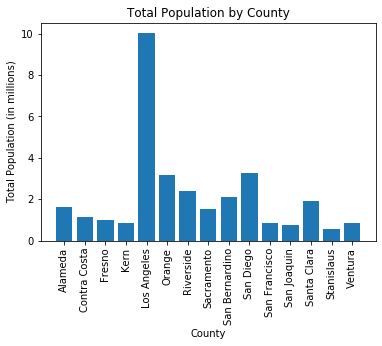

In [11]:
county_x_values = range(len(data_county.county_population))

ax = plt.subplot()

plt.bar(county_x_values, data_county.county_population)

plt.xlabel('County')
plt.ylabel('Total Population (in millions)')
plt.title('Total Population by County')

ax.set_xticks(county_x_values)
ax.set_xticklabels(data_county.county, rotation = 90)
ax.set_yticks([0, 2000000, 4000000, 6000000, 8000000, 10000000])
ax.set_yticklabels([0, 2, 4, 6, 8, 10])


plt.show()

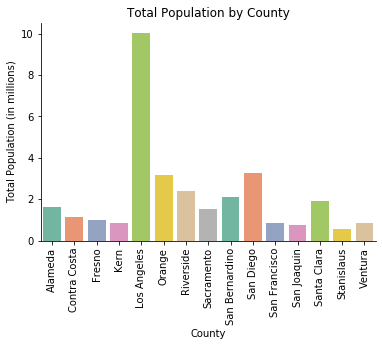

In [49]:
ax = plt.subplot()

sns.barplot(data = data_county, x = 'county', y = 'county_population')

plt.xlabel('County')
plt.ylabel('Total Population (in millions)')
plt.title('Total Population by County')

ax.set_xticks(county_x_values)
ax.set_xticklabels(data_county.county, rotation = 90)
ax.set_yticks([0, 2000000, 4000000, 6000000, 8000000, 10000000])
ax.set_yticklabels([0, 2, 4, 6, 8, 10])

sns.despine()

custom_palette = sns.color_palette('Set2', 9)
sns.set_palette(custom_palette)

plt.show()

Now let's see the poverty levels in each county. Our ACS dataset already includes the percentage of individuals in each poverty level, which makes it easy to compare poverty levels for counties with different population sizes. 

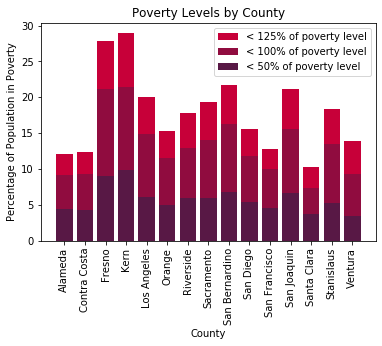

In [13]:
ax = plt.subplot()

plt.bar(county_x_values, data_county.county_125_poverty, color = '#C70039')
plt.bar(county_x_values, data_county.county_100_poverty, color = '#900C3F')
plt.bar(county_x_values, data_county.county_50_poverty, color = '#581845')

plt.legend(['< 125% of poverty level','< 100% of poverty level','< 50% of poverty level'])

plt.xlabel('County')
plt.ylabel('Percentage of Population in Poverty')
plt.title('Poverty Levels by County')

ax.set_xticks(county_x_values)
ax.set_xticklabels(data_county.county, rotation = 90)

plt.show()

We can see that Kern and Fresno counties have the highest rates of poverty, while Santa Clara, Alameda, and Contra Costa have the lowest rates. 

Why is this the case? Let's investigate if the location of counties impacts their poverty levels.

We'll start by assigning each county to either an "inland" or "coastal" label. 

(Python will throw us a warning because we're editing the county copy of our main DataFrame and not the original DataFrame itself. This is fine; we're only going to be analyzing the location in relation to the county. We could add this column to our main DataFrame in the future if we wanted to run different analyses but I won't waste time on it now.)

In [14]:
data_county['location'] = ['coastal', 'coastal', 'inland', 'inland', 'coastal', 'coastal', 'inland', 'inland', 'inland', 'coastal', 'coastal', 'inland', 'coastal', 'inland', 'coastal']

/Applications/miniconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We will eventually run a chi-square test to see if there is a statistically significant difference in poverty levels between the 15 most populous inland and coastal counties of California. First let's see if there is an obvious difference in poverty levels between the two locations.

In [15]:
poverty_by_location = data_county[['county', 'location', 'county_125_poverty']]
poverty_by_location

,county,location,county_125_poverty
0,Alameda,coastal,12.1
1,Contra Costa,coastal,12.4
2,Fresno,inland,27.9
3,Kern,inland,28.9
4,Los Angeles,coastal,20.0
5,Orange,coastal,15.3
6,Riverside,inland,17.8
7,Sacramento,inland,19.3
8,San Bernardino,inland,21.7
9,San Diego,coastal,15.6


In [16]:
poverty_by_location_grouped = poverty_by_location.groupby('location').county_125_poverty.mean().reset_index()
poverty_by_location_grouped

,location,county_125_poverty
0,coastal,14.037500
1,inland,22.157143


It looks like the populous inland counties have a higher rate of poverty, on average. 

Now let's run our chi-square test. This will be a little time consuming because we must find the *number* of people in poverty in each county, not the *percentage*. We also need to find the number of people *not* in poverty. We can find this by multiplying the percentages by the county population size.

(We'll get a warning again; we're not trying to edit our original DataFrame, just run some analyses in place on our copy, so this is fine.)

In [17]:
poverty_by_location = data_county[['county', 'location', 'county_125_poverty', 'county_population']]
poverty_by_location['number_poverty'] = poverty_by_location.county_population * poverty_by_location.county_125_poverty / 100
poverty_by_location['number_not_poverty'] = poverty_by_location.county_population - poverty_by_location.number_poverty
poverty_by_location

/Applications/miniconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/miniconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,county,location,county_125_poverty,county_population,number_poverty,number_not_poverty
0,Alameda,coastal,12.1,1636780,198050.380,1438729.620
1,Contra Costa,coastal,12.4,1138850,141217.400,997632.600
2,Fresno,inland,27.9,972580,271349.820,701230.180
3,Kern,inland,28.9,860951,248814.839,612136.161
4,Los Angeles,coastal,20.0,10015695,2003139.000,8012556.000
5,Orange,coastal,15.3,3154479,482635.287,2671843.713
6,Riverside,inland,17.8,2385745,424662.610,1961082.390
7,Sacramento,inland,19.3,1509927,291415.911,1218511.089
8,San Bernardino,inland,21.7,2093857,454366.969,1639490.031
9,San Diego,coastal,15.6,3256674,508041.144,2748632.856


Let's group these results so we can plug them into our chi-square test.

In [18]:
poverty_by_location_grouped2 = poverty_by_location.groupby('location')['number_poverty', 'number_not_poverty'].sum().reset_index()
poverty_by_location_grouped2

,location,number_poverty,number_not_poverty
0,coastal,3756226.934,1.906726e+07
1,inland,1944706.948,7.152156e+06


Now let's run our chi-square test!

In [19]:
location_table = [[3756227, 1944707],
                  [19067260, 7152156]]

total_population = 0

for list in location_table:
    for i in list:
        total_population += i

chi2, pval, dof, expected = chi2_contingency(location_table)

print(chi2, pval, dof)
print(total_population)

107327.22932763721 0.0 1
31920350


We have such a large chi-square value and such a small p-value because our sample size is so large. This is to be expected; when working with Census data, even the smallest patterns tend to come up significant, and this pattern is quite a prominent one. 

We can interpret the results of our test as follows.

There is a significant difference in poverty levels between populous inland and populous coastal counties in California. Populous inland counties have higher rates of poverty, on average. χ²(1, N = 31,930,350) = 107327.23, p < 0.001. 

### Poverty by Sex

Are there significant differences in poverty levels between males and females in the most populous counties of California? Let's see.

We can start by visualizing our relevant data to see if any obvious patterns emerge.

First let's graph gender differences in poverty levels for each county. Later we will combine our data to visualize overall gender differences within our whole dataset. 

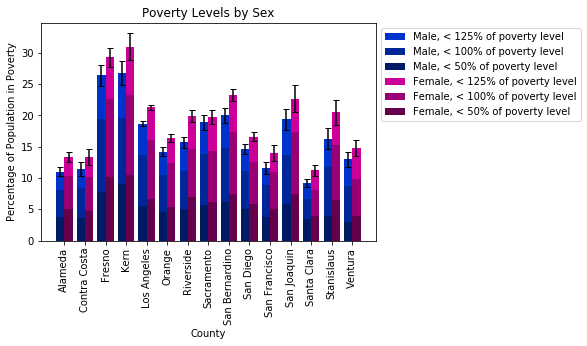

In [68]:
def create_x(t, w, n, d):
    return [t * x + w * n for x in range(d)]

sex_x_values1 = create_x(2, 0.8, 1, 15)
sex_x_values2 = create_x(2, 0.8, 2, 15)

sex_middle_x = [(a + b) / 2.0 for a, b in zip(sex_x_values1, sex_x_values2)]

ax = plt.subplot()

plt.bar(sex_x_values1, data_sex.male_125_poverty, yerr = data_sex.male_125_poverty_error, capsize = 3, color = '#0033cc', label = 'Male, < 125% of poverty level')
plt.bar(sex_x_values1, data_sex.male_100_poverty, color = '#002699', label = 'Male, < 100% of poverty level')
plt.bar(sex_x_values1, data_sex.male_50_poverty, color = '#001a66', label = 'Male, < 50% of poverty level')

plt.bar(sex_x_values2, data_sex.female_125_poverty, yerr = data_sex.female_125_poverty_error, capsize = 3, color = '#cc0099', label = 'Female, < 125% of poverty level')
plt.bar(sex_x_values2, data_sex.female_100_poverty, color = '#990073', label = 'Female, < 100% of poverty level')
plt.bar(sex_x_values2, data_sex.female_50_poverty, color = '#66004d', label = 'Female, < 50% of poverty level')

plt.legend(bbox_to_anchor = (1.0, 1.0))

plt.xlabel('County')
plt.ylabel('Percentage of Population in Poverty')
plt.title('Poverty Levels by Sex')

ax.set_xticks(sex_middle_x)
ax.set_xticklabels(data_county.county, rotation = 90)





plt.show()

It looks like females have higher rates of poverty in every populous county in California. 

Is this difference significant? Let's run a chi-square test to see.